### Convolutional LSTM

In [39]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.layers import *

import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


#Build Network
Defining the network architecture that consists of an input layer, two convolutional layers, a bidirectional LSTM, a dense layer and an output layer.

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 400, 20)]    0                                            
__________________________________________________________________________________________________
permute_15 (Permute)            (None, 20, 400)      0           input_17[0][0]                   
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 10, 400)      610         permute_15[0][0]                 
__________________________________________________________________________________________________
conv1d_43 (Conv1D)              (None, 10, 400)      1010        permute_15[0][0]                 
___________________________________________________________________________________________

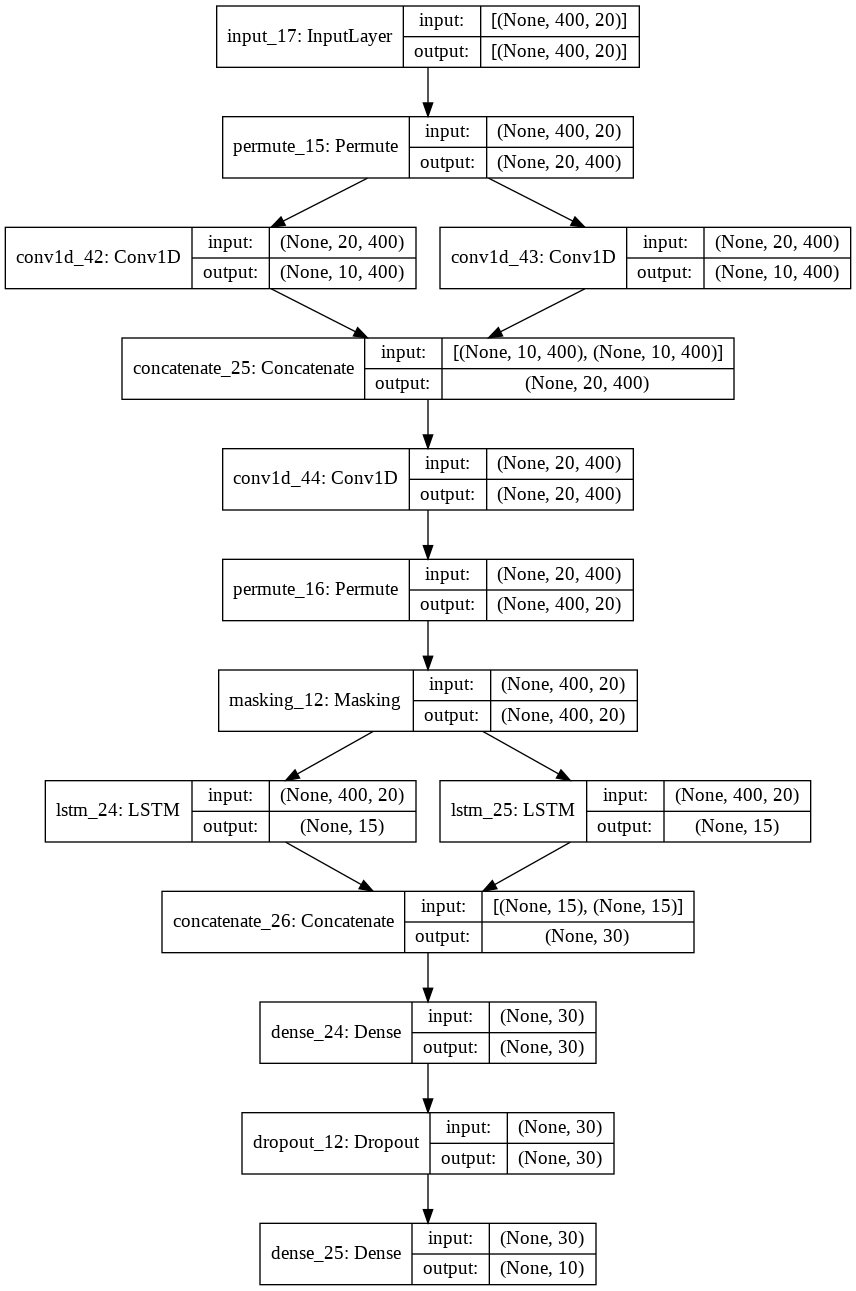

In [41]:
# Set hyperparameters

batch_size = 128
seq_len = 400
n_feat = 20
n_hid = 15
n_class = 10
lr = 0.0025
n_filt = 10
drop_prob = 0.5

# Build model defining the layers
# Define input
l_input = keras.Input(shape=(seq_len, n_feat))

l_permute = layers.Permute((2,1))(l_input)

# Convolutional layers with filter size 3 and 5
l_conv_a = layers.Conv1D(n_filt, 3, strides=1, padding="same", activation="relu", data_format='channels_first')(l_permute)

l_conv_b = layers.Conv1D(n_filt, 5, strides=1, padding="same", activation="relu", data_format='channels_first')(l_permute)

# The output of the two convolution is concatenated
l_conc = tf.keras.layers.Concatenate(axis=1)([l_conv_a, l_conv_b])

# Building a second CNN layer
l_conv_final = layers.Conv1D(n_filt*2, 3, strides=1, padding="same", activation="relu", data_format='channels_first')(l_conc)

# Second permute layer
l_reshu = layers.Permute((2, 1))(l_conv_final)

# mask to ignore the padded positions
l_mask = Masking(mask_value=0.0)(l_reshu)

# Bidirectional LSTM layer, taking only the last hidden state (only_return_final)
l_fwd = layers.LSTM(units=n_hid, activation="tanh", return_sequences=False)(l_mask)
l_bwd = layers.LSTM(units=n_hid, activation="tanh", return_sequences=False, go_backwards=True)(l_mask)

# Concatenate both layers
l_conc_lstm = tf.keras.layers.Concatenate(axis=1)([l_fwd, l_bwd])

# Dense layer with ReLu activation function
l_dense = layers.Dense(n_hid*2, activation="relu")(l_conc_lstm)

# Output layer with a Softmax activation function. Note that we include a dropout layer
l_dropout = layers.Dropout(drop_prob)(l_dense)
l_out = layers.Dense(n_class, activation="softmax")(l_dropout)

model = keras.Model(l_input, l_out)
model.summary()
keras.utils.plot_model(model, "model.png", show_shapes=True)


#Load dasets

In [42]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
_ = tf.compat.v1.Session(config=config)

# Load the encoded protein sequences, labels and masks
train = np.load('/gdrive/My Drive/ProteinsML/Protein-subcellular-localization/data/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']
mask_train = train['mask_train']
#print(X_train.shape)
#print(X_train)

validation = np.load('/gdrive/My Drive/ProteinsML/Protein-subcellular-localization/data/reduced_val.npz')
X_val = validation['X_val']
y_val = validation['y_val']
mask_val = validation['mask_val']
#print(X_val.shape)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



##Model building

In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])
# todo weights normalization?
print(model.summary())
#plot_model(model, "model.png", show_shapes=True)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 400, 20)]    0                                            
__________________________________________________________________________________________________
permute_15 (Permute)            (None, 20, 400)      0           input_17[0][0]                   
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 10, 400)      610         permute_15[0][0]                 
__________________________________________________________________________________________________
conv1d_43 (Conv1D)              (None, 10, 400)      1010        permute_15[0][0]                 
___________________________________________________________________________________________

#Train

In [44]:
y_train = to_categorical(y_train, n_class)
y_val = to_categorical(y_val, n_class)

# Number of epochs
num_epochs = 100

checkpoint = ModelCheckpoint(filepath='/gdrive/My Drive/ProteinsML/Protein-subcellular-localization/weights/CCN_LSTM_weights.hdf5',
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')

# Calculate also the prediction and network loss for the validation set:
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val), shuffle=True, callbacks=[checkpoint])


Epoch 1/100
19/19 [==============================] - 14s 310ms/step - loss: 2.2308 - accuracy: 0.1792 - val_loss: 2.0336 - val_accuracy: 0.2063

Epoch 00001: val_loss improved from inf to 2.03364, saving model to /gdrive/My Drive/ProteinsML/Protein-subcellular-localization/weights/CCN_LSTM_weights.hdf5
Epoch 2/100
19/19 [==============================] - 3s 168ms/step - loss: 2.0824 - accuracy: 0.2011 - val_loss: 1.9846 - val_accuracy: 0.3102

Epoch 00002: val_loss improved from 2.03364 to 1.98465, saving model to /gdrive/My Drive/ProteinsML/Protein-subcellular-localization/weights/CCN_LSTM_weights.hdf5
Epoch 3/100
19/19 [==============================] - 3s 167ms/step - loss: 1.9375 - accuracy: 0.3485 - val_loss: 1.6700 - val_accuracy: 0.4079

Epoch 00003: val_loss improved from 1.98465 to 1.66999, saving model to /gdrive/My Drive/ProteinsML/Protein-subcellular-localization/weights/CCN_LSTM_weights.hdf5
Epoch 4/100
19/19 [==============================] - 3s 168ms/step - loss: 1.7376 

In [47]:
print("Minimum validation loss: {:.6f}".format(min(history.history['val_loss'])))
acc_index = np.argmin(history.history['val_loss'])
print("With accuracy: {:.6f}".format(history.history['val_accuracy'][acc_index]))

Minimum validation loss: 0.675189
With accuracy: 0.806299


## Plot
Plots of loss and accuracy for training and validation set at each epoch.


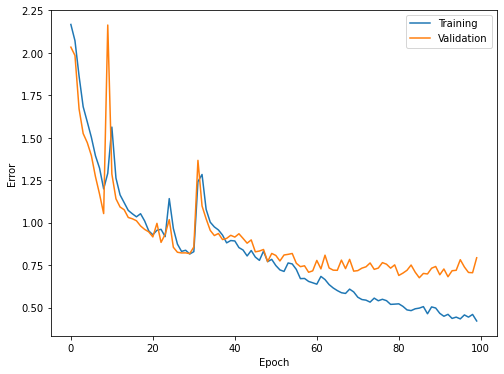

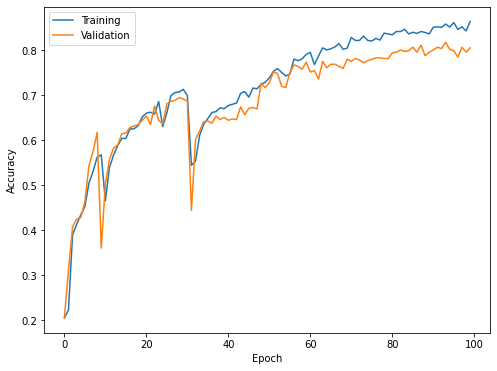

In [45]:
x_axis = range(num_epochs)
plt.figure(figsize=(8, 6))
# loss_training:
plt.plot(x_axis, history.history['loss'])
# loss_validation
plt.plot(x_axis, history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(('Training', 'Validation'))
plt.show()

plt.figure(figsize=(8, 6))
# accuracy training
plt.plot(x_axis, history.history['accuracy'])
# accuracy validation
plt.plot(x_axis, history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Training', 'Validation'))
plt.show()

### Confusion matrix
The confusion matrix shows how well is predicted each class and which are the most common mis-classifications.

Code based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


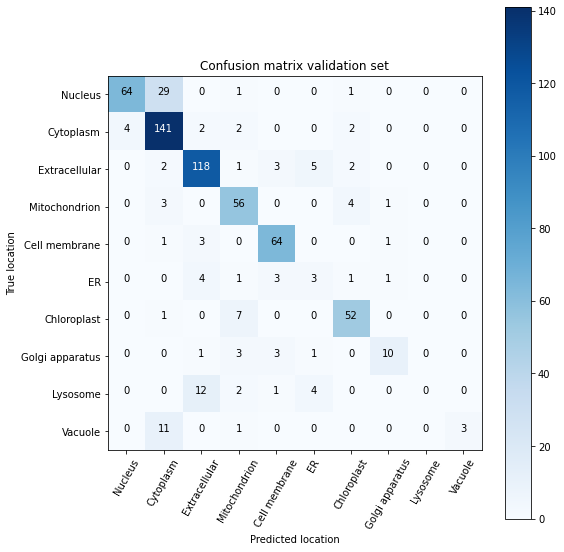

In [46]:
Y_pred = model.predict(X_val)
y_pred = np.argmax(Y_pred, axis=1)

confusion_mat = confusion_matrix(validation['y_val'], y_pred)

plt.figure(figsize=(8, 8))
colormap = plt.cm.Blues
plt.imshow(confusion_mat, interpolation='nearest', cmap=colormap)
plt.title('Confusion matrix validation set')
plt.colorbar()
tick_marks = np.arange(n_class)
classes = ['Nucleus', 'Cytoplasm', 'Extracellular', 'Mitochondrion', 'Cell membrane', 'ER', 'Chloroplast',
                'Golgi apparatus', 'Lysosome', 'Vacuole']

plt.xticks(tick_marks, classes, rotation=60)
plt.yticks(tick_marks, classes)

thresh = confusion_mat.max() / 2.0
for i, j in itertools.product(range(confusion_mat.shape[0]), range(confusion_mat.shape[1])):
    plt.text(j, i, confusion_mat[i, j],
             horizontalalignment="center",
             color="white" if confusion_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True location')
plt.xlabel('Predicted location')
plt.show()